## Estimate aspect solution uncertainty from star centroid residuals

When the ground aspect pipeline gets run there is no accurate estimate of the
aspect solution uncertainty.  One proxy that has been used informally is to
use the aspect solution to de-dither star centroids and thus determine star
centroid residuals (from the mean aspect solution).  The star centroid residuals
have a component from both the true residuals and the aspect solution uncertainty.
Thus one can state that the minimum star centroid standard deviation (out of the
5 to 8 guide stars) represents an upper limit on aspect solution error.
However, this is somewhat circular because the aspect solution is influenced by
the star centroids.

In order to understand the impact of this circularity, this notebook does
a simple simulation:

- Simulate an observation with 5 stars each having a centroid residual sigma of between 0.05 and 0.20 arcsec.  
- Use a "snapshot" method of determining the "aspect solution", which in this case simply means the weighted mean of the observed centroids.  
- This is done for 1-axis only.  
- The actual mean values of the star centroids do not matter and only the standard deviation matters.
- Plot the minimum star standard deviation vs. the aspect solution RMS

Under these assumptions it is seen that the **aspect solution RMS is always less than the minimum star standard deviation**.
 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
N_READOUT = 1000

In [3]:
def sim_obs():
    """
    Simulate an observation with 5 stars each having a centroid residual sigma
    of between 0.05 and 0.20 arcsec.  Use a "snapshot" method of determining the
    "aspect solution", which in this case simply means the weighted mean of the
    observed centroids.  This is done for 1-axis only.  The actual mean values
    of the star centroids does not matter and is just set to 0.0.
    
    :returns: RMS of aspect solution, stddev of centroid residuals
    """
    # Star centroid residual sigmas
    n_stars = 5
    sigmas = np.random.uniform(0.05, 0.20, size=n_stars)
    
    # Simulated star centroids (all with mean value 0.0)
    y = np.random.normal(size=(N_READOUT, n_stars)) * sigmas
    
    # Aspect solution as weighted average of star centroids
    y_asol = np.average(y, weights=1/sigmas, axis=1)
    
    # Measured residuals from "aspect solution" and std dev
    y_resid = y.T - y_asol
    y_resid_std = np.std(y_resid, axis=1)
    
    return np.sqrt(np.mean(y_asol ** 2)), np.min(y_resid_std)

In [4]:
n_sim = 1000
yc_std = np.zeros(n_sim)
yr_std_min = np.zeros(n_sim)

for i in range(n_sim):
    yc_std[i], yr_std_min[i] = sim_obs()

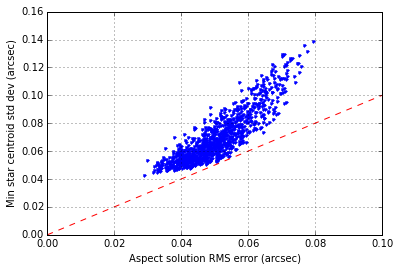

In [5]:
plt.plot(yc_std, yr_std_min, '.')
plt.plot([0.0, 0.14], [0.0, 0.14], '--r')
plt.grid()
plt.xlabel('Aspect solution RMS error (arcsec)')
plt.ylabel('Min star centroid std dev (arcsec)')
plt.xlim(0, 0.1);

**Figure 1** - plot showing the minimum star centroid standard deviation (out of 5 stars) versus simulated aspect solution RMS error in one axis.  This highlights that the minimum star centroid stddev seen in the set of 5 stars is always greater than the true aspect solution error.  This assumes gaussian statistics and an instantaneous "snapshot" method of deriving the aspect solution (weighted mean).  In reality the Kalman filter uses gyro data and optimal filtering, so the actual error for Chandra aspect solutions should be even smaller.

Therefore the **minimum star centroid standard deviation** for an observation is a reasonable upper limit on the image reconstruction RMS error.